<a href="https://colab.research.google.com/github/virtualthree/Plant-Disease-Detection/blob/main/NIA-VGG-ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score
from sklearn.neighbors import KNeighborsClassifier


# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']
    
    # Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    print(x.shape)
    print(xt.shape)
    xtrain  = xt[:, x == 1] #x: 1Xdim, dim=train_data , xt=X_train, xtrain = train_data
    print(xtrain.shape)
    ytrain  = yt.reshape(num_train)  # Solve bug
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  # Solve bug   
    # Training
    mdl     = KNeighborsClassifier(n_neighbors = k)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc
    
    return error


# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)
        
    return cost



In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#from drive.MyDrive.FS.hho import jfs   # change this to switch algorithm 
import matplotlib.pyplot as plt

# load data
data  = pd.read_csv('drive/My Drive/train_features_2.csv')
print(type(data))


<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(type(data))
data = np.nan_to_num(data)
feat  = np.asarray(data[:, 0:-1])   # feature vector
label = np.asarray(data[:, -1])     # label vector
print(feat.shape)
print(label.shape)
#print(feat)
#print(label)

<class 'pandas.core.frame.DataFrame'>
(1280, 112897)
(1280,)


In [ ]:
print(feat)

[[0.0000000e+00 0.0000000e+00 3.7643247e+00 ... 1.6527282e+00
  9.8007750e-01 2.4967009e-01]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.1229088e+00
  4.7591677e-01 4.1517510e+00]
 [2.0000000e+00 0.0000000e+00 9.3453884e-02 ... 3.3830078e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.2770000e+03 0.0000000e+00 1.9777336e+00 ... 2.3223736e+00
  0.0000000e+00 0.0000000e+00]
 [1.2780000e+03 0.0000000e+00 0.0000000e+00 ... 4.0879640e+00
  5.7469547e-02 3.1744835e-01]
 [1.2790000e+03 0.0000000e+00 0.0000000e+00 ... 2.7961204e+00
  0.0000000e+00 1.9631972e+00]]


In [ ]:
print(label)

from sklearn import preprocessing
from sklearn import utils
lab_enc = preprocessing.LabelEncoder()
label = lab_enc.fit_transform(label)
print(np.unique(label))
print(label)

[4. 2. 1. ... 6. 6. 2.]
[0 1 2 3 4 5 6 7 8]
[4 2 1 ... 6 6 2]


In [ ]:
#[2016]-"The whale optimization algorithm"]

import numpy as np
from numpy.random import rand
from drive.MyDrive.FS.functionHO import Fun


def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X


def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x


def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    b     = 1       # constant
    
    N        = opts['N']
    max_iter = opts['T']
    if 'b' in opts:
        b    = opts['b']
    
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position 
    X    = init_position(lb, ub, N, dim)
    
    # Binary conversion
    Xbin = binary_conversion(X, thres, N, dim)
    
    # Fitness at first iteration
    fit  = np.zeros([N, 1], dtype='float')
    Xgb  = np.zeros([1, dim], dtype='float')
    fitG = float('inf')
    
    for i in range(N):
        fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
        if fit[i,0] < fitG:
            Xgb[0,:] = X[i,:]
            fitG     = fit[i,0]
        
    # Pre
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    curve[0,t] = fitG.copy()
    print("Generation:", t + 1)
    print("Best (WOA):", curve[0,t])
    t += 1

    while t < max_iter:
        # Define a, linearly decreases from 2 to 0 
        a = 2 - t * (2 / max_iter)
        
        for i in range(N):
            # Parameter A (2.3)
            A = 2 * a * rand() - a
            # Paramater C (2.4)
            C = 2 * rand()
            # Parameter p, random number in [0,1]
            p = rand()
            # Parameter l, random number in [-1,1]
            l = -1 + 2 * rand()  
            # Whale position update (2.6)
            if p  < 0.5:
                # {1} Encircling prey
                if abs(A) < 1:
                    for d in range(dim):
                        # Compute D (2.1)
                        Dx     = abs(C * Xgb[0,d] - X[i,d])
                        # Position update (2.2)
                        X[i,d] = Xgb[0,d] - A * Dx
                        # Boundary
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
                
                # {2} Search for prey
                elif abs(A) >= 1:
                    for d in range(dim):
                        # Select a random whale
                        k      = np.random.randint(low = 0, high = N)
                        # Compute D (2.7)
                        Dx     = abs(C * X[k,d] - X[i,d])
                        # Position update (2.8)
                        X[i,d] = X[k,d] - A * Dx
                        # Boundary
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
            
            # {3} Bubble-net attacking 
            elif p >= 0.5:
                for d in range(dim):
                    # Distance of whale to prey
                    dist   = abs(Xgb[0,d] - X[i,d])
                    # Position update (2.5)
                    X[i,d] = dist * np.exp(b * l) * np.cos(2 * np.pi * l) + Xgb[0,d] 
                    # Boundary
                    X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
        
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitG:
                Xgb[0,:] = X[i,:]
                fitG     = fit[i,0]
        
        # Store result
        curve[0,t] = fitG.copy()
        print("Generation:", t + 1)
        print("Best (WOA):", curve[0,t])
        t += 1            

            
    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)    
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    woa_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return woa_data 

In [ ]:
# split data into train & validation (70 -- 30)
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.3)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

# parameter
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 20   # maximum number of iterations
b  = 1    # constant
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'b':b}

# perform feature selection
fmdl = jfs(feat, label, opts)
sf   = fmdl['sf']



[0 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 1 0 1]
[1 1 0 ... 1 0 0]
[0 0 0 ... 0 1 0]
[1 0 1 ... 0 1 0]
[0 0 1 ... 0 1 1]
[1 0 1 ... 0 0 1]
[1 0 0 ... 0 0 1]
[0 0 0 ... 0 1 1]
Generation: 1
Best (WOA): 0.27053806165686417
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[1 1 0 ... 1 0 1]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[1 0 0 ... 1 1 1]
Generation: 2
Best (WOA): 0.2615534548360453
[1 1 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
Generation: 3
Best (WOA): 0.25499225026462174
[0 1 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 1 1 ... 0 0 0]
[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 1 ... 0 0 0]
[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
Generation: 4
Best (WOA): 0.25499225026462174
[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 1 ... 0 0 0]
[0 1 1 ... 0 0 1]
[0 1 1 ... 0 0 0]
[0 1 1 

Accuracy: 74.73958333333334
Feature Size: 53150


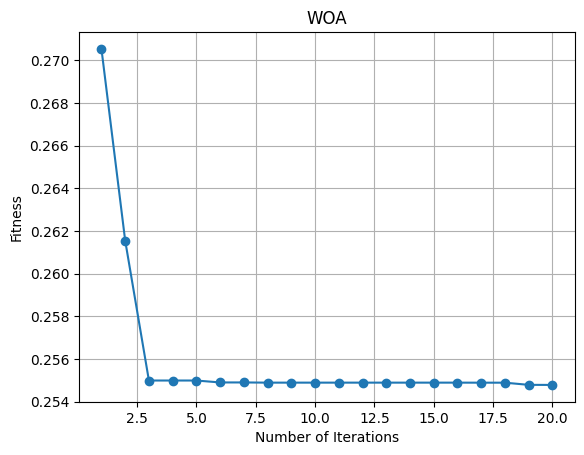

In [ ]:
# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

mdl       = KNeighborsClassifier(n_neighbors = k) 
mdl.fit(x_train, y_train)

# accuracy
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
print("Accuracy:", 100 * Acc)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('WOA')
ax.grid()
plt.show()

In [ ]:
from sklearn.svm import SVC # SVM
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier

print(np.unique(y_train))
mdl       = RandomForestClassifier() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)

print("Random Forest Classifier")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))


mdl       = AdaBoostClassifier() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
print("Ada Boost Classiifer")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))

mdl       = SVC() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
print("SVM Classifier")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))


[0 1 2 3 4 5 6 7 8]
Random Forest Classifier
Time taken : 7.811211585998535

accuracy : 100.0%
F1_score : 1.0
Recall : 1.0
Precision : 1.0
Ada Boost Classiifer
Time taken : 143.51522517204285

accuracy : 36.38%
F1_score : 0.3622
Recall : 0.3638
Precision : 0.4115
SVM Classifier
Time taken : 70.72604155540466

accuracy : 99.44%
F1_score : 0.9944
Recall : 0.9944
Precision : 0.9945


In [ ]:
import numpy as np
from numpy.random import rand
from drive.MyDrive.FS.functionHO import Fun


def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X


def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]
        
    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()
        
    return V, Vmax, Vmin


def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x
    

def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor
    
    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2'] 
    
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    
    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    while t < max_iter:
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]
        
        # Store result
        curve[0,t] = fitG.copy()
        print("Iteration:", t + 1)
        print("Best (PSO):", curve[0,t])
        t += 1
        
        for i in range(N):
            for d in range(dim):
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d]) 
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
    
                
    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return pso_data    

In [ ]:
# split data into train & validation (70 -- 30)
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.3)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

# parameter
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 20   # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(feat, label, opts)
sf   = fmdl['sf']

[1 0 1 ... 0 1 0]
[0 1 0 ... 1 1 0]
[1 0 1 ... 1 1 1]
[1 1 0 ... 0 1 1]
[0 0 0 ... 1 1 0]
[1 1 1 ... 1 1 1]
[1 0 1 ... 1 1 0]
[0 0 0 ... 0 0 0]
[1 1 0 ... 1 0 1]
[0 1 0 ... 0 0 1]
Iteration: 1
Best (PSO): 0.2705523224432447
[0 0 0 ... 1 1 0]
[0 0 0 ... 0 1 0]
[1 0 1 ... 0 0 1]
[1 0 0 ... 1 0 1]
[1 0 1 ... 0 1 1]
[1 0 1 ... 0 1 0]
[1 1 0 ... 1 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
Iteration: 2
Best (PSO): 0.2705523224432447
[0 0 0 ... 1 0 0]
[0 0 1 ... 0 1 0]
[0 0 0 ... 0 1 0]
[1 0 1 ... 1 0 1]
[1 0 1 ... 0 0 0]
[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 1 0 ... 0 0 0]
Iteration: 3
Best (PSO): 0.2704917362452058
[0 0 0 ... 1 0 0]
[0 0 1 ... 1 0 0]
[0 0 0 ... 0 1 0]
[1 0 1 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 1 0]
[1 0 1 ... 0 0 0]
[0 0 1 ... 0 1 0]
[1 1 1 ... 0 0 0]
Iteration: 4
Best (PSO): 0.26773070115902103
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 1 0 ... 1 

Accuracy: 76.04166666666666
Feature Size: 55731


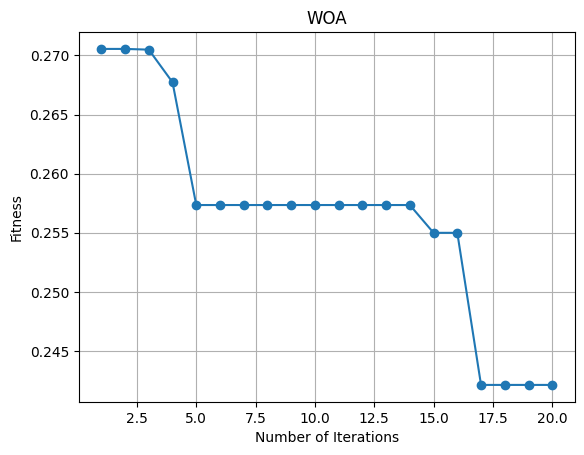

[0 1 2 3 4 5 6 7 8]
Random Forest Classifier
Time taken : 7.846375942230225

accuracy : 100.0%
F1_score : 1.0
Recall : 1.0
Precision : 1.0
Ada Boost Classiifer
Time taken : 147.4504690170288

accuracy : 29.24%
F1_score : 0.2714
Recall : 0.2924
Precision : 0.3852
SVM Classifier
Time taken : 67.78414583206177

accuracy : 99.44%
F1_score : 0.9944
Recall : 0.9944
Precision : 0.9945


In [ ]:
# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

mdl       = KNeighborsClassifier(n_neighbors = k) 
mdl.fit(x_train, y_train)

# accuracy
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
print("Accuracy:", 100 * Acc)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('WOA')
ax.grid()
plt.show()

from sklearn.svm import SVC # SVM
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier

print(np.unique(y_train))
mdl       = RandomForestClassifier() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)

print("Random Forest Classifier")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))


mdl       = AdaBoostClassifier() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
print("Ada Boost Classiifer")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))

mdl       = SVC() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
print("SVM Classifier")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))


In [ ]:
#[2016]-"Jaya: A simple and new optimization algorithm for solving  constrained and unconstrained optimization problems"

import numpy as np
from numpy.random import rand
from drive.MyDrive.FS.functionHO import Fun


def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X


def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x
    

def jfs(xtrain, ytrain, opts):
    # Parameters
    ub     = 1
    lb     = 0
    thres  = 0.5
    
    N          = opts['N']
    max_iter   = opts['T']
        
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position 
    X     = init_position(lb, ub, N, dim)
    
    # Binary conversion
    Xbin  = binary_conversion(X, thres, N, dim)
    
    # Fitness at first iteration
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    
    for i in range(N):
        fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
        if fit[i,0] < fitG:
            Xgb[0,:] = X[i,:]
            fitG     = fit[i,0]
    
    # Pre
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    curve[0,t] = fitG.copy()
    print("Generation:", t + 1)
    print("Best (JA):", curve[0,t])
    t += 1
    
    while t < max_iter:  
        Xnew  = np.zeros([N, dim], dtype='float') 
        
        # Identify best & worst in population
        idx_max = np.argmax(fit)
        Xw      = X[idx_max,np.newaxis,:].copy()
        idx_min = np.argmin(fit)
        Xb      = X[idx_min,np.newaxis,:].copy()       
          
        for i in range(N):
            for d in range(dim):
                # Random numbers
                r1 = rand();
                r2 = rand();
                # Position update (1)
                Xnew[i,d] = X[i,d] + r1 * (Xb[0,d] - abs(X[i,d])) - r2 * (Xw[0,d] - abs(X[i,d])) 
                # Boundary
                Xnew[i,d] = boundary(Xnew[i,d], lb[0,d], ub[0,d])
                
        # Binary conversion
        Xbin = binary_conversion(Xnew, thres, N, dim)
        
        # Greedy selection
        for i in range(N):
            Fnew = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if Fnew < fit[i,0]:
                X[i,:]   = Xnew[i,:]
                fit[i,0] = Fnew             
                
            if fit[i,0] < fitG:
                Xgb[0,:] = X[i,:]
                fitG     = fit[i,0]
             
        # Store result
        curve[0,t] = fitG.copy()
        print("Generation:", t + 1)
        print("Best (JA):", curve[0,t])
        t += 1            

            
    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    ja_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return ja_data  

In [ ]:
# split data into train & validation (70 -- 30)
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.3)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

# parameter
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 20   # maximum number of iterations
opts = {'k':k, 'fold':fold, 'N':N, 'T':T}

# perform feature selection
fmdl = jfs(feat, label, opts)
sf   = fmdl['sf']

[0 1 0 ... 0 1 0]
[1 0 1 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 1 1 ... 0 1 1]
[1 0 1 ... 1 1 0]
[0 0 0 ... 0 0 0]
[1 0 1 ... 0 0 0]
[0 0 1 ... 1 0 1]
[1 0 1 ... 0 1 1]
[1 0 0 ... 1 0 0]
Generation: 1
Best (JA): 0.2189784846751907
[0 1 0 ... 0 1 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 1 0 ... 0 1 1]
[1 0 1 ... 1 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 1 0 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 0 0]
Generation: 2
Best (JA): 0.2189784846751907
[0 1 0 ... 0 1 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 1 1 ... 0 1 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 1 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
Generation: 3
Best (JA): 0.2189784846751907
[0 1 0 ... 0 1 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 1 1 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 1 ... 1 0 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
Generation: 4
Best (JA): 0.2189784846751907
[0 1 0 ... 0 1 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 1 0 ... 0 1 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0

Accuracy: 78.90625
Feature Size: 56351


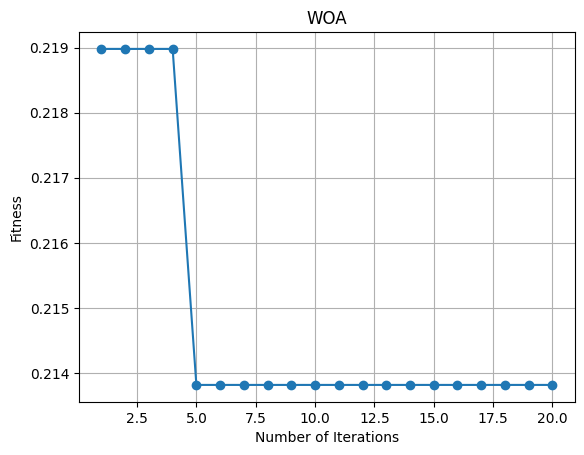

[0 1 2 3 4 5 6 7 8]
Random Forest Classifier
Time taken : 8.155161142349243

accuracy : 100.0%
F1_score : 1.0
Recall : 1.0
Precision : 1.0
Ada Boost Classiifer
Time taken : 149.14969086647034

accuracy : 38.5%
F1_score : 0.3689
Recall : 0.385
Precision : 0.442
SVM Classifier
Time taken : 62.79559779167175

accuracy : 99.67%
F1_score : 0.9967
Recall : 0.9967
Precision : 0.9968


In [ ]:
# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

mdl       = KNeighborsClassifier(n_neighbors = k) 
mdl.fit(x_train, y_train)

# accuracy
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
print("Accuracy:", 100 * Acc)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('WOA')
ax.grid()
plt.show()

from sklearn.svm import SVC # SVM
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier

print(np.unique(y_train))
mdl       = RandomForestClassifier() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)

print("Random Forest Classifier")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))


mdl       = AdaBoostClassifier() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
print("Ada Boost Classiifer")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))

mdl       = SVC() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
print("SVM Classifier")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))


In [ ]:
#[2019]-"Harris hawks optimization: Algorithm and applications"

import numpy as np
from numpy.random import rand
from drive.MyDrive.FS.functionHO import Fun
import math


def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X


def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x


def levy_distribution(beta, dim):
    # Sigma 
    nume  = math.gamma(1 + beta) * np.sin(np.pi * beta / 2)
    deno  = math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)
    sigma = (nume / deno) ** (1 / beta)
    # Parameter u & v 
    u     = np.random.randn(dim) * sigma
    v     = np.random.randn(dim)
    # Step 
    step  = u / abs(v) ** (1 / beta)
    LF    = 0.01 * step    

    return LF


def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    beta  = 1.5    # levy component
    
    N        = opts['N']
    max_iter = opts['T']
    if 'beta' in opts:
        beta = opts['beta']
        
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position 
    X     = init_position(lb, ub, N, dim)
    
    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xrb   = np.zeros([1, dim], dtype='float')
    fitR  = float('inf')
            
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    while t < max_iter:
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitR:
                Xrb[0,:] = X[i,:]
                fitR     = fit[i,0]
                
        # Store result
        curve[0,t] = fitR.copy()
        print("Iteration:", t + 1)
        print("Best (HHO):", curve[0,t])
        t += 1

        # Mean position of hawk (2)
        X_mu      = np.zeros([1, dim], dtype='float')
        X_mu[0,:] = np.mean(X, axis=0)
        
        for i in range(N):
            # Random number in [-1,1]
            E0 = -1 + 2 * rand()
            # Escaping energy of rabbit (3)
            E  = 2 * E0 * (1 - (t / max_iter)) 
            # Exploration phase
            if abs(E) >= 1:
                # Define q in [0,1]
                q = rand()
                if q >= 0.5:
                    # Random select a hawk k
                    k  = np.random.randint(low = 0, high = N)
                    r1 = rand()
                    r2 = rand()
                    for d in range(dim):
                        # Position update (1)
                        X[i,d] = X[k,d] - r1 * abs(X[k,d] - 2 * r2 * X[i,d])
                        # Boundary
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])

                elif q < 0.5:    
                    r3 = rand() 
                    r4 = rand()
                    for d in range(dim):
                        # Update Hawk (1)
                        X[i,d] = (Xrb[0,d] - X_mu[0,d]) - r3 * (lb[0,d] + r4 * (ub[0,d] - lb[0,d]))
                        # Boundary
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
                        
            # Exploitation phase 
            elif abs(E) < 1:
                # Jump strength 
                J = 2 * (1 - rand()) 
                r = rand()
                # {1} Soft besiege
                if r >= 0.5 and abs(E) >= 0.5:
                    for d in range(dim):
                        # Delta X (5)
                        DX     = Xrb[0,d] - X[i,d]
                        # Position update (4)
                        X[i,d] = DX - E * abs(J * Xrb[0,d] - X[i,d])
                        # Boundary
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
                        
                # {2} hard besiege
                elif r >= 0.5 and abs(E) < 0.5:
                    for d in range(dim):
                        # Delta X (5)
                        DX     = Xrb[0,d] - X[i,d]
                        # Position update (6)
                        X[i,d] = Xrb[0,d] - E * abs(DX)    
                        # Boundary
                        X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
                        
                # {3} Soft besiege with progressive rapid dives
                elif r < 0.5 and abs(E) >= 0.5:
                    # Levy distribution (9)
                    LF = levy_distribution(beta, dim) 
                    Y  = np.zeros([1, dim], dtype='float')
                    Z  = np.zeros([1, dim], dtype='float')
                    
                    for d in range(dim):
                        # Compute Y (7)
                        Y[0,d] = Xrb[0,d] - E * abs(J * Xrb[0,d] - X[i,d])
                        # Boundary
                        Y[0,d] = boundary(Y[0,d], lb[0,d], ub[0,d])
                        
                    for d in range(dim):
                        # Compute Z (8)
                        Z[0,d] = Y[0,d] + rand() * LF[d]
                        # Boundary
                        Z[0,d] = boundary(Z[0,d], lb[0,d], ub[0,d])          
                    
                    # Binary conversion
                    Ybin = binary_conversion(Y, thres, 1, dim)
                    Zbin = binary_conversion(Z, thres, 1, dim)
                    # fitness
                    fitY = Fun(xtrain, ytrain, Ybin[0,:], opts)
                    fitZ = Fun(xtrain, ytrain, Zbin[0,:], opts)
                    # Greedy selection (10)
                    if fitY < fit[i,0]:
                        fit[i,0]  = fitY 
                        X[i,:]    = Y[0,:]
                    if fitZ < fit[i,0]:
                        fit[i,0]  = fitZ
                        X[i,:]    = Z[0,:]                        

                # {4} Hard besiege with progressive rapid dives
                elif r < 0.5 and abs(E) < 0.5:
                    # Levy distribution (9)
                    LF = levy_distribution(beta, dim) 
                    Y  = np.zeros([1, dim], dtype='float')
                    Z  = np.zeros([1, dim], dtype='float')
                    
                    for d in range(dim):
                        # Compute Y (12)
                        Y[0,d] = Xrb[0,d] - E * abs(J * Xrb[0,d] - X_mu[0,d])
                        # Boundary
                        Y[0,d] = boundary(Y[0,d], lb[0,d], ub[0,d])
                    
                    for d in range(dim):
                        # Compute Z (13)
                        Z[0,d] = Y[0,d] + rand() * LF[d]
                        # Boundary
                        Z[0,d] = boundary(Z[0,d], lb[0,d], ub[0,d])    

                    # Binary conversion
                    Ybin = binary_conversion(Y, thres, 1, dim)
                    Zbin = binary_conversion(Z, thres, 1, dim)
                    # fitness
                    fitY = Fun(xtrain, ytrain, Ybin[0,:], opts)
                    fitZ = Fun(xtrain, ytrain, Zbin[0,:], opts)
                    # Greedy selection (10)
                    if fitY < fit[i,0]:
                        fit[i,0]  = fitY
                        X[i,:]    = Y[0,:]
                    if fitZ < fit[i,0]:
                        fit[i,0]  = fitZ
                        X[i,:]    = Z[0,:]  


    # Best feature subset
    Gbin       = binary_conversion(Xrb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    hho_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return hho_data

In [ ]:
# split data into train & validation (70 -- 30)
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.3)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

# parameter
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 20   # maximum number of iterations
opts = {'k':k, 'fold':fold, 'N':N, 'T':T}

# perform feature selection
fmdl = jfs(feat, label, opts)
sf   = fmdl['sf']

[1 0 1 ... 1 1 1]
[0 0 0 ... 0 1 0]
[0 1 1 ... 0 1 0]
[1 0 0 ... 1 0 1]
[0 1 1 ... 1 0 0]
[0 0 1 ... 0 0 1]
[0 0 0 ... 0 1 0]
[1 1 0 ... 0 1 1]
[1 1 0 ... 0 0 0]
[1 0 1 ... 1 1 1]
Iteration: 1
Best (HHO): 0.23186937540412939
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 1 ... 0 1 1]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 1]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
Iteration: 2
Best (HHO): 0.22162519057747324
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 1]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
Iteration: 3
Best (HHO): 0.22162519057747324
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[

Accuracy: 78.125
Feature Size: 29815


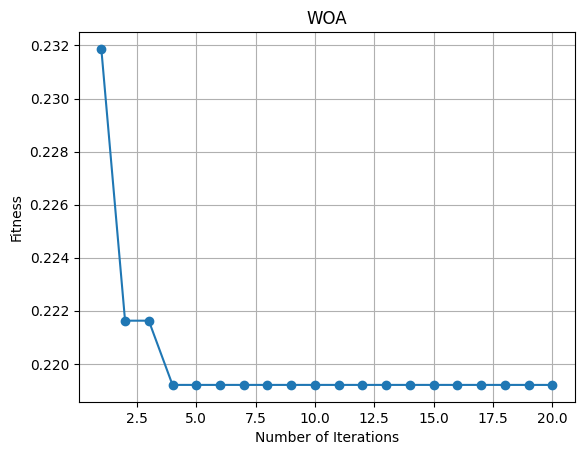

[0 1 2 3 4 5 6 7 8]
Random Forest Classifier
Time taken : 6.276670694351196

accuracy : 100.0%
F1_score : 1.0
Recall : 1.0
Precision : 1.0
Ada Boost Classiifer
Time taken : 77.28156280517578

accuracy : 33.93%
F1_score : 0.3108
Recall : 0.3393
Precision : 0.4292
SVM Classifier
Time taken : 32.176339626312256

accuracy : 99.22%
F1_score : 0.9922
Recall : 0.9922
Precision : 0.9923


In [ ]:
# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

mdl       = KNeighborsClassifier(n_neighbors = k) 
mdl.fit(x_train, y_train)

# accuracy
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
print("Accuracy:", 100 * Acc)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('WOA')
ax.grid()
plt.show()

from sklearn.svm import SVC # SVM
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier

print(np.unique(y_train))
mdl       = RandomForestClassifier() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)

print("Random Forest Classifier")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))


mdl       = AdaBoostClassifier() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
print("Ada Boost Classiifer")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))

mdl       = SVC() 
start = time.time()
mdl.fit(x_train, y_train)
end = time.time()

# accuracy
y_pred_train= mdl.predict(x_train)

train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
print("SVM Classifier")
print("Time taken : {}".format(end-start))
print()
print("accuracy : {}%".format(train_accuracy))
print("F1_score : {}".format(train_F1))
print("Recall : {}".format(train_recall))
print("Precision : {}".format(train_precision))
